In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import pandas as pd
from functools import partial

from prepare_plasticc import config
from tokenizer import LCTokenizer
from viz import plot_lightcurve
from gaussian_process import fit_2d_gp
import time

from models.patchgpt import PatchGPT
import torch

/opt/anaconda3/envs/gpt-ts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('plasticc/plasticc_train_lightcurves.csv.gz')
#df = pd.read_csv('plasticc/plasticc_test_lightcurves_02.csv.gz')

In [3]:
object_ids = np.unique(df['object_id'].values)

In [4]:
tokenizer = LCTokenizer(-10000, 10000, 500, 1000, 500, bands=config["bands"],
                            transform=np.arcsinh, inverse_transform=np.sinh,
                            min_sn=3, window_size=5)

In [5]:
start_time = time.time()
#tokenizer.encode(df)
print(time.time() - start_time)

2.288818359375e-05


0.30312108993530273


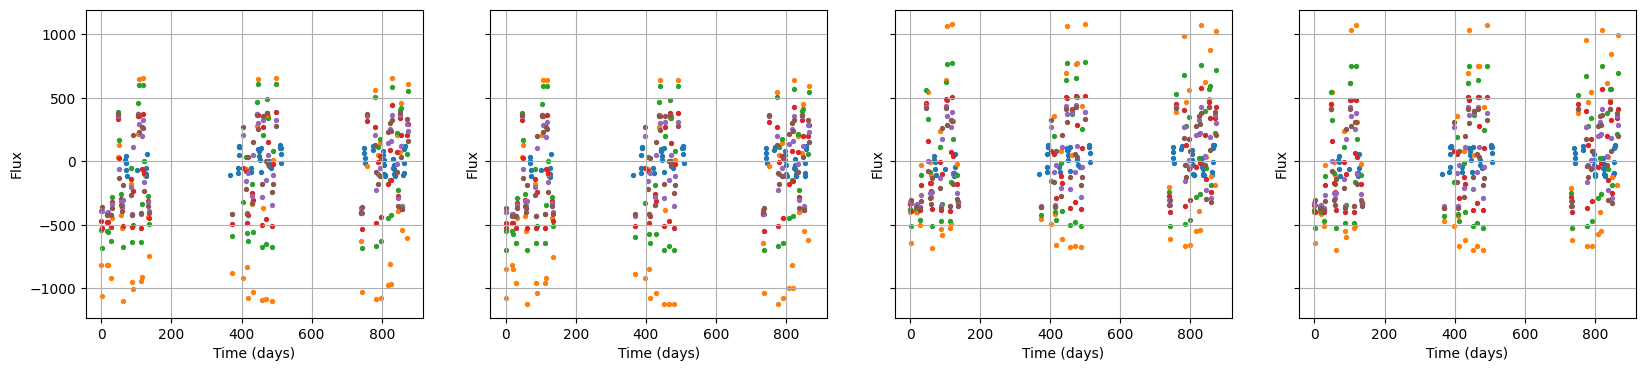

In [6]:
for object_id in object_ids[0:1]:
    df_object = df.loc[df['object_id'] == object_id]
    df_object.loc[:, 'mjd'] = df_object.loc[:, 'mjd'] - min(df_object['mjd']) 
    start_time = time.time()
    resampled_df, (sampled_times, sampled_obs, _, sampled_mask), _ = fit_2d_gp(df_object, config['pb_wavelengths'], sample_interval=1)
    print(time.time() - start_time)
    plot_lightcurve([df_object, tokenizer.decode(tokenizer.encode(df_object)), resampled_df, tokenizer.decode(tokenizer.encode(resampled_df))])

In [7]:
patch_size = 5

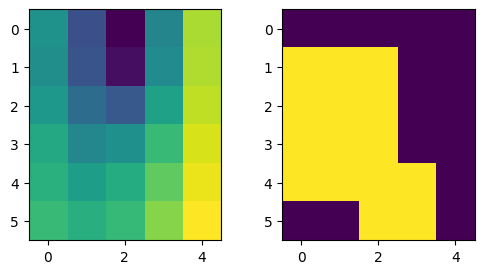

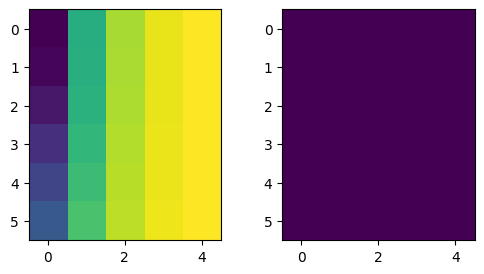

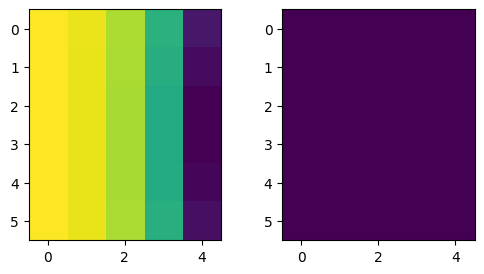

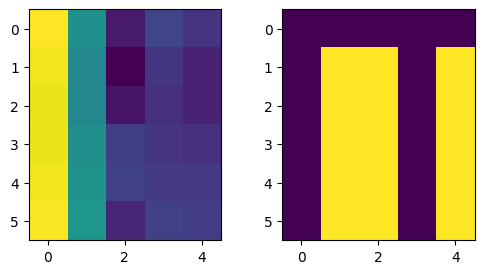

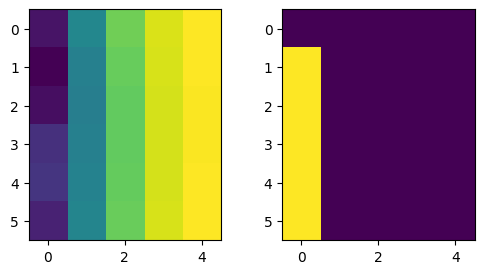

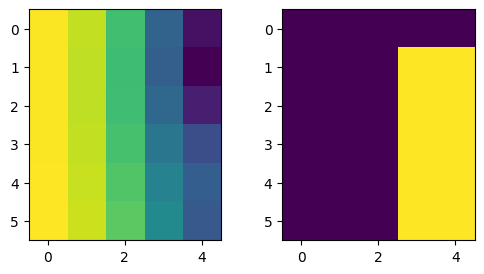

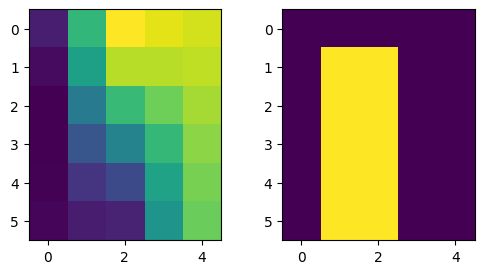

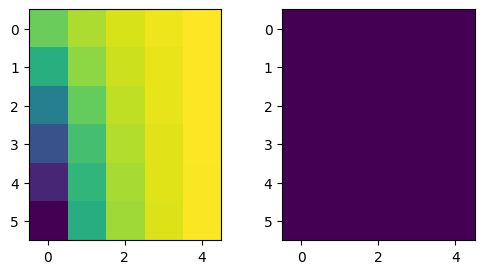

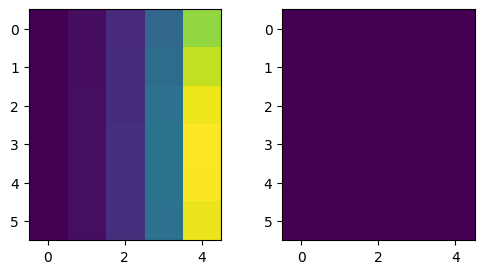

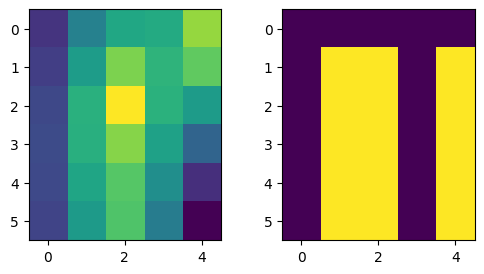

In [8]:
for i in range(10):
    fig, axes = plt.subplots(1,2, figsize=(6,3))
    axes[0].imshow(sampled_obs[:,i*patch_size:(i+1)*patch_size])
    axes[1].imshow(sampled_mask[:,i*patch_size:(i+1)*patch_size])
    plt.show()

In [9]:
patchify = PatchGPT(patch_size=patch_size, n_embd=18, channels=6, n_layer=2, n_positions=1024, n_head=3)

TypeError: PatchGPT.__init__() got an unexpected keyword argument 'patch_size'

In [ ]:
patchify

In [ ]:
x = torch.tensor(np.expand_dims(np.arcsinh(sampled_obs), 0), dtype=torch.float32).transpose(1, 2)
mask = torch.tensor(np.expand_dims(sampled_mask, 0), dtype=torch.int32).transpose(1, 2)

In [ ]:
x.shape

In [ ]:
output = patchify(x, attention_mask=mask)

In [ ]:
output.loss

In [ ]:
plt.plot(output.patch_pred[0,1,:].detach().numpy())

In [ ]:
plt.plot(output.patch_mask[0,:].detach().numpy())

In [ ]:
dd = np.load('plasticc/train_gp_samples.npy', allow_pickle=True)